In [1]:
import numpy as np
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import matplotlib as mpl
import types
from skimage import measure
import pickle

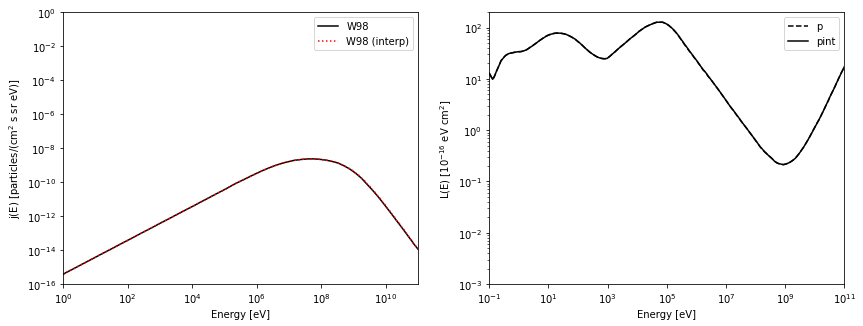

In [2]:
# Load proton spectra from Padovani (and others)
file_W98 = "data/W98.csv"
w98 = types.SimpleNamespace()
w98.energy, w98.spectrum = np.loadtxt(file_W98, delimiter=',', comments='#', unpack=True)
w98.energyInterp = np.logspace(0, 11, num=10000, endpoint=True)
fint_W98 = scipy.interpolate.interp1d(w98.energy, w98.spectrum, kind='linear', assume_sorted=True)
w98.spectrumInterp = fint_W98(w98.energyInterp)

# Load Energy loss function L(E) from Padovani
file_protons = "data/energyLoss_protons.csv"
pLoss = types.SimpleNamespace()
pLoss.E, pLoss.L = np.loadtxt(file_protons, delimiter=',', comments='#', unpack=True)

pLoss.Einterp = np.logspace(-1, 11, num=2000, endpoint=True)
fint_LE = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True)
pLoss.Linterp = fint_LE(pLoss.Einterp)

fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].loglog(w98.energy, w98.spectrum, 'k-', label="W98")
axs[0].loglog(w98.energyInterp, w98.spectrumInterp, 'r:', label='W98 (interp)')
axs[0].set_xlim(1,1e11)
axs[0].set_ylim(1e-16,1)
axs[0].set_xlabel("Energy [eV]")
axs[0].set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
axs[0].legend()

axs[1].loglog(pLoss.E, pLoss.L, 'k--', label="p")
axs[1].loglog(pLoss.Einterp, pLoss.Linterp, 'k-', label="pint")
axs[1].set_xlabel("Energy [eV]")
axs[1].set_ylabel("L(E) [10$^{-16}$ eV cm$^2$]")
axs[1].set_xlim(1e-1,1e11)
axs[1].set_ylim(1e-3,2e2)
axs[1].legend()
fout = 'out/spectraAndEnergyLossFunctions.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

In [3]:
# Compute the range of a particle (proton) given an energy loss function
# by integrating the energy loss function until the particle is at rest.
def rangeOfE(EE, dEdN):
    # Einit: initial particle energy [eV]
    # dEdN: energy loss function (1e-16 eV cm2)
    # EE: corresponding energies for dEdN (eV)
    dE = EE[1:]-EE[:-1]

    ranges = []
    #nn = len(dEdN)-1
    nn = len(dE)
    
    integrand = dE/dEdN[1:]
    for ii in range(nn):
        ranges.append(np.sum(integrand[0:ii]))

    return ranges

nn, min, max of pLoss.Einterp: 2000, 0.1, 100000000000.0


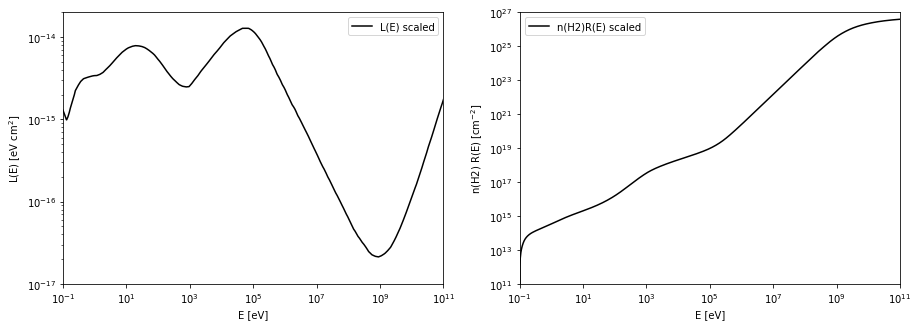

In [4]:
# Follow procedure in Padovani to find j(E,N) from j(E0,0)

# Vary E and E0 from 0.1eV to 100 GeV, determine column density from the difference betwen R(E0) and R(E)
# N(H2) ~ R(E0)-R(E) (see Padovani Equation 21)
# Make contour plot of N(H2) vs. E0 and E
# Pick a single contour (a fixed value of N(H2)) and fit E0 = (cE^b + N/N0)^(1/b)
#.   this tells us what the starting energy E0 is for a given ending energy E
# Once you know the E0 <--> E mapping, you can compute j(E,N) from j(E0,0) and L(E0)/L(E)

print(f'nn, min, max of pLoss.Einterp: {len(pLoss.Einterp)}, {min(pLoss.Einterp)}, {max(pLoss.Einterp)}')

RR = rangeOfE(pLoss.Einterp, pLoss.Linterp)  
# units of pLoss.Linterp are 1e-16 eV cm^2, so "range" is really n(H2)*R(E) and has units of 1e16 cm^{-2}

# convert Linterp to units of eV cm^2
pLossScaled = types.SimpleNamespace()
pLossScaled.E = pLoss.Einterp[:]
pLossScaled.L = pLoss.Linterp[:]*1e-16
RRscaled = rangeOfE(pLossScaled.E, pLossScaled.L)  

# Compute level contours of N(H2)/n(H2) =  R(E0)-R(E)
E0s, EEs = np.meshgrid(pLossScaled.E[1:], pLossScaled.E[1:])
R0s, REs = np.meshgrid(RRscaled, RRscaled)
NNs = R0s-REs

figN, axN = plt.subplots(1, 2, figsize=(15,5))
axN[0].loglog(pLossScaled.E, pLossScaled.L, 'k-', label='L(E) scaled')
axN[0].set_xlim(1e-1, 1e11)
axN[0].set_ylim(1e-17, 2e-14)
axN[0].set_xlabel("E [eV]")
axN[0].set_ylabel("L(E) [eV cm$^2$]")
axN[0].legend()

axN[1].loglog(pLossScaled.E[1:], RRscaled, 'k-', label='n(H2)R(E) scaled')
axN[1].set_xlim(1e-1, 1e11)
axN[1].set_ylim(1e11, 1e27)
axN[1].set_xlabel("E [eV]")
axN[1].set_ylabel("n(H2) R(E) [cm$^{-2}$]")
axN[1].legend()

fout = 'out/energyLossAndRangePadovani.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

<ipython-input-5-e89d8c488439>:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs = axs4[0].contour(EEs, E0s, NNs, levels=levels, norm=LogNorm())#, locator=ticker.LogLocator())#, cmap=cm.PuBu_r)


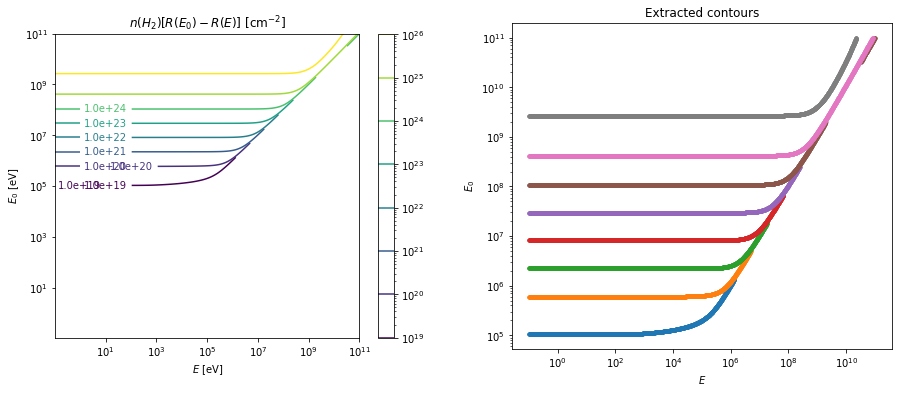

In [5]:
# VISUALIZE N(H2) CONTOURS
# Nothing in this cell depends on the input spectrum, only on L(E)
fig4, axs4 = plt.subplots(1, 2, figsize=(15,6))
#levels = np.logspace(17, 24, num=8, endpoint=True)
#levels = np.logspace(17, 26, num=10, endpoint=True)
levels = np.logspace(19, 26, num=8, endpoint=True)
cs = axs4[0].contour(EEs, E0s, NNs, levels=levels, norm=LogNorm())#, locator=ticker.LogLocator())#, cmap=cm.PuBu_r)
axs4[0].set_xscale('log')
axs4[0].set_yscale('log')
axs4[0].axis('scaled')
axs4[0].set_xlabel("$E$ [eV]")
axs4[0].set_ylabel("$E_0$ [eV]")
axs4[0].set_title("$n(H_2)[R(E_0)-R(E)]$ [cm$^{-2}$]")
fig4.colorbar(cs, ax=axs4[0], shrink=0.93)
locs = [(10, 1e3), (10, 1e4), (10, 1e5), (10, 1e6), (10, 1e6),
        (10, 1e6), (10, 1e7), (10, 1e8)]#, (10, 1e9)]#, (10, 1e10)]
axs4[0].clabel(cs, cs.levels, inline=True, fmt="%.1e", fontsize=10, manual=locs)


contourData = []
# pick out the x/y coordinates of each contour
for levelId, level in enumerate(levels):
    for ii in range(len(cs.allsegs[levelId])):
        if ii == 0:
            xEs  = cs.allsegs[levelId][ii][:,0]
            yE0s = cs.allsegs[levelId][ii][:,1]
        else:
            xEs  = np.concatenate((xEs,  cs.allsegs[levelId][ii][:,0]))
            yE0s = np.concatenate((yE0s, cs.allsegs[levelId][ii][:,1]))
    # sort in ascending order of xEs
    ids = np.argsort(xEs)
    xEs = xEs[ids]
    yE0s = yE0s[ids]
    contourData.append([xEs[:],yE0s[:]])
   
# save the results as a pickle file
data = {'levels':levels, 'contours':contourData}
with open('testFit.pkl', 'wb') as ff:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, ff)

#print(f"cs.allsegs[{levelId}] = ")
#print(cs.allsegs[levelId])

#axs4[0].plot(xEs, yE0s, 'r-') # overplot on contour graph
for ii in range(len(contourData)):
    axs4[1].loglog(contourData[ii][0], contourData[ii][1], '.')
#axs4[1].plot(xEs, yE0s, 'r.')
#axs4[1].set_xscale('log')
#axs4[1].set_yscale('log')
axs4[1].set_xlabel("$E$")
axs4[1].set_ylabel("$E_0$")
axs4[1].set_title("Extracted contours")
#axs4[1].set_title(f"Contour of $n(H_2) [R(E0)-R(E)]$ for $N(H_2)$={NH2s:.3e}")

fout = 'out/NH2Contours.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

# ##################################################################
# # try finding contours another way...
# # Find contours at a constant value of 0.8
# fig7, axs7 = plt.subplots(1, 2, figsize=(15,6))
# extent = [pLossScaled.E[1], pLossScaled.E[-1], pLossScaled.E[1], pLossScaled.E[-1]] # [xmin, xmax, ymin, ymax]
# #axs7[0].imshow(NNs.T, cmap=plt.cm.gray, origin='lower', norm=LogNorm(), extent=extent)
# pcm = axs7[0].pcolormesh(pLossScaled.E[1:], pLossScaled.E[1:], NNs.T, norm=LogNorm())
# axs7[0].set_xscale('log')
# axs7[0].set_yscale('log')
# fig7.colorbar(pcm, ax=axs7[0], shrink=1)
# axs7[1].plot([],[])
# axs7[1].set_xscale('log')
# axs7[1].set_yscale('log')
# level0 = 1e24
# for level in levels:
#     print(f"level = {level:.2e}")
#     contours = measure.find_contours(NNs, level)
#     # Display the image and plot all contours found
#     for contour in contours:
#         #xx = pLossScaled.E[contour[:,0].astype('int')]
#         #yy = pLossScaled.E[contour[:,1].astype('int')]
#         axs7[0].plot(contour[:, 0], contour[:, 1], linewidth=2)
#         #axs7[0].plot(xx, yy, linewidth=2)
#         if level==level0:
#             #axs7[1].plot(xx, xx, linewidth=2)
#             axs7[1].plot(contour[:, 0], contour[:, 1], linewidth=2)




In [6]:
# # Now that fitting works, we don't need to do interpolation...
# # So this cell is "defunct"

# # interpolate L(E) onto our E0 and E values
# fint_LE = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True) # FIXME: this is a repeat from above...
# LE_E0 = fint_LE(yE0s)
# LE_E  = fint_LE(xEs)

# # interpolate j(E0,0) onto our E0 values
# fint_w98 = scipy.interpolate.interp1d(w98.energy, w98.spectrum, kind='linear', assume_sorted=True) 
# jjw98 = fint_w98(yE0s)

# nE = len(yE0s)
# jjDegraded = []
# for ii in range(nE):
#     Ei = xEs[ii]
#     E0i = yE0s[ii]
#     jjDegraded.append( fint_w98(E0i)*fint_LE(E0i)/fint_LE(Ei) )
    
# jjDegraded = np.array(jjDegraded)


# # Read in degraded spectrum data from Padovani (Figure 9)
# file_W98 = "data/W98_degraded_1e24.csv"
# w98DegradedPadovani = types.SimpleNamespace()
# w98DegradedPadovani.energy1e24, w98DegradedPadovani.spectrum1e24 = np.loadtxt(file_W98, delimiter=',', comments='#', unpack=True)


# fig9, axs9 = plt.subplots(1, 1, figsize=(7,5))
# axs9.loglog(yE0s, jjw98, 'k--', label='W98 input spectrum')
# NH2s = 1e99
# axs9.loglog(xEs, jjDegraded, 'k-', label=f'My degraded spectrum for N(H2) = {NH2s:.2e}')
# axs9.loglog(w98DegradedPadovani.energy1e24, w98DegradedPadovani.spectrum1e24, 'r:', label=f'Padovani: N(H2)={1e24}')
# axs9.set_xlim(1e-1, 1e10)
# axs9.set_ylim(1e-14, 1e-8)
# axs9.set_xlabel("E [eV]")
# axs9.set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
# axs9.legend()
# fout = 'out/spectrumOriginalAndDegraded.pdf'
# plt.savefig(fout)
# plt.savefig(fout.replace(".pdf",".png"))

# # fig9, axs9 = plt.subplots(1, 2, figsize=(15,5))
# # axs9[0].loglog(pLossScaled.E, pLossScaled.L, 'k-')
# # axs9[0].set_xlim(1e-1, 1e11)
# # axs9[0].set_ylim(1e-19, 2e-14)
# # axs9[0].set_xlabel("E [eV]")
# # axs9[0].set_ylabel("L(E) [eV cm$^2$]")

# # axs9[1].loglog(yE0s, jjw98, 'k--')
# # axs9[1].loglog(xEs, jjDegraded, 'k-')
# # axs9[1].set_xlim(1e-1, 1e11)
# # axs9[1].set_xlabel("E [eV]")
# # axs9[1].set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
# fout = 'out/W98_degraded.pdf'
# plt.savefig(fout)
# plt.savefig(fout.replace(".pdf",".png"))
    

In [7]:
# Exploring the E0 vs. E relation (from Padovani, Eqn. 26)
# E0(Ek,N) = ( c E^b + N/N0)^(1/b)
%matplotlib inline
import ipywidgets as widgets

#  N(H2)  c     b     N0
#  1e17   0.85  1.20  7.94e13
#  1e21   0.77  1.03  3.16e14
#  1e24   1.02  1.70  2.24e10
#  1e25   1.06  1.03  1.50e+16 or...
#  1e25   0.88  1.14  1.41e+15
#  1e26   1.06  1.03  2.00e+16
####  1e17   1.01  0.82  9.4e14


id = -2
NN = data['levels'][id]
def f(c, b, N0):
    print(f"c, b, N0 = {c}, {b}, {N0}")
    plt.figure(2)
    EE = np.logspace(-1, 11, num=1000)
    plt.loglog(data['contours'][id][0], data['contours'][id][1], 'k.')
    plt.loglog(EE, (c*EE**b + NN/N0)**(1/b), 'r-' )
    plt.xlabel("E")
    plt.ylabel("E0")
    plt.title(f"N(H2) = {NN:.1e}")
    plt.show()

w = widgets.interactive(f, 
                        c=widgets.FloatSlider(value=1.06, min=0.1, max=5.0, step=0.01,
                                             continuous_update=False), 
                        b=widgets.FloatSlider(value=1.03, min=0.5, max=2.0, step=0.01,
                                             continuous_update=False), 
                        N0=widgets.FloatLogSlider(value=1.5e16,
                                                  base=10, 
                                                  min=14, # max exponent of base
                                                  max=18, # min exponent of base
                                                  step=0.05, # exponent step
                                                  description='N0 (log)',
                                                 continuous_update=False)
                       )
display(w)


interactive(children=(FloatSlider(value=1.06, continuous_update=False, description='c', max=5.0, min=0.1, step…

1e+19
   c          9.12e-01
   b          1.03e+00
   N0         6.65e+13
   N          1.00e+19
1e+20
   c          8.87e-01
   b          1.15e+00
   N0         2.33e+13
   N          1.00e+20
1e+21
   c          8.97e-01
   b          1.21e+00
   N0         2.03e+13
   N          1.00e+21
1e+22
   c          9.03e-01
   b          1.25e+00
   N0         2.29e+13
   N          1.00e+22
1e+23
   c          9.31e-01
   b          1.35e+00
   N0         8.70e+12
   N          1.00e+23
1e+24
   c          1.02e+00
   b          1.36e+00
   N0         1.21e+13
   N          1.00e+24
1e+25
   c          1.21e+00
   b          1.25e+00
   N0         2.12e+14
   N          1.00e+25
1e+26
   c          5.00e+00
   b          1.21e+00
   N0         4.70e+14
   N          1.00e+26


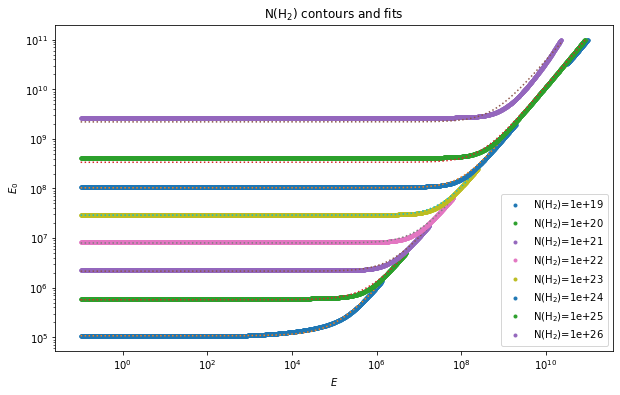

In [8]:
# Fits!
from lmfit import create_params, minimize
from lmfit.printfuncs import report_fit, fit_report

# E0(Ek,N) = ( c E^b + N/N0)^(1/b)
def residual(pars, x, data=None):
    c = pars['c']
    b = pars['b']
    N0 = pars['N0']
    N  = pars['N']
    model = (c*x**b + N/N0)**(1/b)
    if data is None:
        return model
    return model - data

with open('testFit.pkl', 'rb') as ff:
    data = pickle.load(ff)
# data['contours'][ii] is the x, y data for contour [ii]
# data['levels'][ii] is the N(H2) value for the ii-th contour

#  1e17   0.85  1.20  7.94e13
# For 1e17 to 1e26
#c0 = [0.85, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.02, 1.06, 1.06]
#b0 = [1.20, 1.21, 1.21, 1.21, 1.21, 1.21, 1.21, 1.00, 1.03, 1.03]
#N0 = [7.94e13, 1.8e13, 1.8e13, 1.8e13,
#      1.8e13, 1.8e12, 1.8e11, 2.24e10, 1.5e16, 2.0e16]
## For 1e19 to 1e26
c0 = [0.75, 0.77, 0.75, 0.75, 0.75, 1.02, 0.88, 1.06]
b0 = [1.21, 1.03, 1.21, 1.21, 1.21, 1.00, 1.14, 1.03]
N0 = [1.8e13, 3.2e14, 1.8e13, 1.8e12, 1.8e11, 2.24e10, 1.41e15, 2.0e16]

params = []
outs = []
fits = []
rpts = []
for ii, level in enumerate(data['levels']):
    print(f'{data["levels"][ii]}')
    vary = True
    if ii==0:
        vary = True
    params.append(create_params(c=dict(value=c0[ii], max=5.0, min=0.1, vary=vary),
                                b=dict(value=b0[ii], max=5.0, min=0.1, vary=vary),
                                N0=dict(value=N0[ii], max=1e24, min=1e4, vary=vary),
                                N=dict(value=data['levels'][ii], vary=False)))
    outs.append(minimize(residual, params[-1], 
                         args=(data['contours'][ii][0],), 
                         kws={'data':data['contours'][ii][1]}))
    fits.append(residual(outs[-1].params, data['contours'][ii][0]))
    rpts.append(f'N(H2) = {data["levels"][ii]}\n')
    for name, param in outs[-1].params.items():
        print(f'   {name:7s} {param.value:11.2e}')
    #rpts.append(report_fit(outs[-1], correl_mode='table'))
    #rpts.append(fit_report(outs[-1], correl_mode='table'))
    #rpts.append("\n")

with open('fit_results.dat', 'w') as fout:
    for line in rpts:
        fout.write(line)
    
fig10, axs10 = plt.subplots(1, 1, figsize=(10,6))
for ii in range(len(params)):
    axs10.loglog(data['contours'][ii][0], data['contours'][ii][1], '.', label=f"N(H$_2$)={data['levels'][ii]:.0e}")
    axs10.loglog(data['contours'][ii][0], fits[ii], ':')
axs10.legend()
axs10.set_title("N(H$_2$) contours and fits")
axs10.set_xlabel("$E$")
axs10.set_ylabel("$E_0$")
fout = 'out/NH2ContoursWithFits.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))


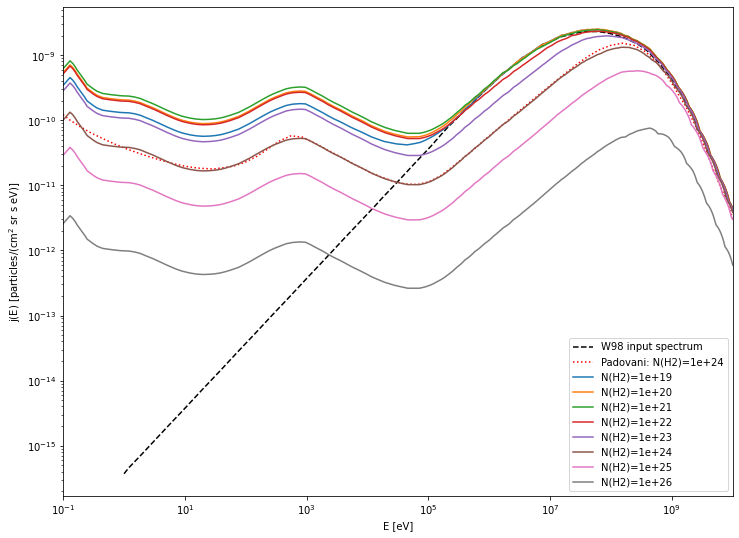

In [9]:
# Degrade the spectrum and compare with Padovani's Figure 9

# x-values for input spectrum are w98.energy
# L(E) is provided by fint_LE = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True)
#w98.energyInterp = np.logspace(0, 11, num=2000, endpoint=True)
#fint_W98 = scipy.interpolate.interp1d(w98.energy, w98.spectrum, kind='linear', assume_sorted=True)
#w98.spectrumInterp = fint_W98(w98.energyInterp)

EE = np.logspace(-1, 10, num=10000, endpoint=True)

# loop over each NH2 contour value
jjDegraded = []
for ii, level in enumerate(data['levels']):
    #print(level)
    E0 = residual(outs[ii].params, EE, data=None)
    jjDegraded.append( fint_W98(E0)*fint_LE(E0)/fint_LE(EE) )
    
    
# Read in degraded spectrum data from Padovani (Figure 9)
file_W98 = "data/W98_degraded_1e24.csv"
w98DegradedPadovani = types.SimpleNamespace()
w98DegradedPadovani.energy1e24, w98DegradedPadovani.spectrum1e24 = np.loadtxt(file_W98, delimiter=',', comments='#', unpack=True)

fig9, axs9 = plt.subplots(1, 1, figsize=(12,9))
axs9.loglog(w98.energyInterp, w98.spectrumInterp, 'k--', label='W98 input spectrum')
axs9.loglog(w98DegradedPadovani.energy1e24, w98DegradedPadovani.spectrum1e24, 'r:', label=f'Padovani: N(H2)={1e24}')
for ii in range(len(jjDegraded)):
    axs9.loglog(EE, jjDegraded[ii], '-', label=f"N(H2)={data['levels'][ii]:.0e}")#, label=f'My degraded spectrum for N(H2) = {NH2s:.2e}')
axs9.set_xlim(1e-1, 1e10)
#axs9.set_ylim(1e-14, 1e-8)
axs9.set_xlabel("E [eV]")
axs9.set_ylabel("j(E) [particles/(cm$^2$ sr s eV)]")
axs9.legend()
fout = 'out/spectrumOriginalAndDegraded.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))


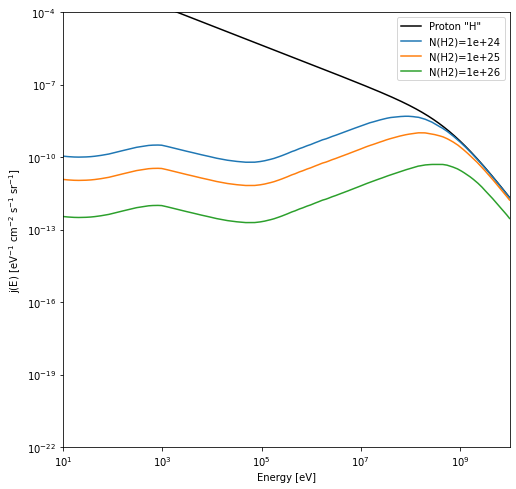

In [10]:
# "Padovani" model for proton and electrons
def crSpectrum(E, species='pH'):
    # alpha=-0.8, beta=1.9, C=2.4e15, E0=650e6):
    if species == 'pH':  # proton, "high"
        C, E0, alpha, beta = 2.4e15, 650e6, -0.8, 1.9
    elif species == 'pL': # proton, "low"
        C, E0, alpha, beta = 2.4e15, 650e6, 0.1, 2.8
    elif species == 'elec': # electron
        C, E0, alpha, beta = 2.1e18, 710e6, -1.3, 1.9
    else:
        print(f"Unrecognized species: {species}")
        return E
    return C*E**alpha/(E+E0)**beta

EE = np.logspace(0, 10, num=2000, endpoint=True)
pH = crSpectrum(EE, species='pH')
pL = crSpectrum(EE, species='pL')
elec = crSpectrum(EE, species='elec')

# Degrade the spectrum
# loop over each NH2 contour value
jjDegraded = []
for ii, level in enumerate(data['levels']):
    #print(level)
    E0 = residual(outs[ii].params, EE, data=None)
    jjDegraded.append( crSpectrum(E0)*fint_LE(E0)/fint_LE(EE) )

def N_of_Sigma(sigma, Abar=2): 
    # compute the column density for a given surface density
    # sigma given in g/cm2, N given in 1/cm2
    # Abar is the mean molecular weight of the medium (Abar=2 for molecular hydrogen H2)
    mp = 1.67262192e-24 # gram
    return sigma/(Abar*mp)

def Sigma_of_N(NN, Abar=2): 
    # compute the column density for a given surface density
    # sigma given in g/cm2, N given in 1/cm2
    # Abar is the mean molecular weight of the medium (Abar=2 for molecular hydrogen H2)
    mp = 1.67262192e-24 # gram
    return Abar*mp*NN


figZ, axsZ = plt.subplots(1, 1, figsize=(8, 8))
axsZ.loglog(EE, pH, 'k-', label='Proton "H"')
#axsZ.loglog(EE, pL, 'r-', label='L')
#plt.loglog(EE, elec, 'k--', label='e-')
for ii in range(len(jjDegraded)):
    if data['levels'][ii] < 1e24:
        continue
    axsZ.loglog(EE, jjDegraded[ii], '-', label=f"N(H2)={data['levels'][ii]:.0e}")

axsZ.set_xlabel("Energy [eV]")
axsZ.set_ylabel("j(E) [eV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
axsZ.set_ylim(1e-22, 1e-4)
axsZ.set_xlim(10, 1e10)
plt.legend();

In [11]:
print(N_of_Sigma(10))

2.989318709873179e+24


In [12]:
print(Sigma_of_N(1e26))
print(plt.style.available)

334.52438400000005
['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


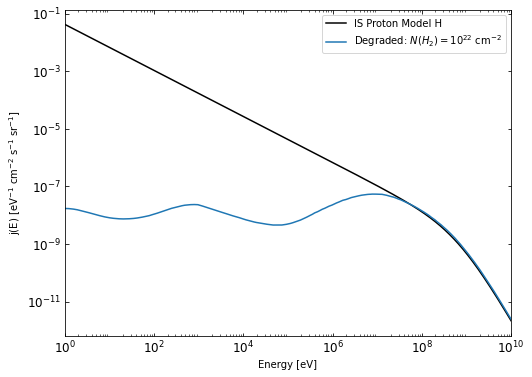

In [20]:
# Show the one N(H2) value we care about: N(H2) = 1e22 cm^-2
figY, axsY = plt.subplots(1, 1, figsize=(8, 6))
axsY.loglog(EE, pH, 'k-', label='IS Proton Model H')
#axsY.loglog(EE, pL, 'r-', label='L')
#axsY.loglog(EE, elec, 'k--', label='e-')

# Extract one particular level (NH2=1e22)
id22 = np.where(data['levels'] == 1e22)[0][0]
axsY.loglog(EE, jjDegraded[id22], '-', label="Degraded: $N(H_2)=10^{22}$ cm$^{-2}$")

axsY.set_xlabel("Energy [eV]")
axsY.set_ylabel("j(E) [eV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
#axsY.set_ylim(1e-11, 1e-7)
axsY.set_xlim(1, 1e10)
axsY.tick_params(axis='both', which='both', direction='in', right=True, top=True, labelsize='large')
axsY.xaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))
axsY.yaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))
axsY.legend()
plt.savefig('inputA')

# save the data
dd = {'E':EE, 'ModelH':pH, 'ModelH_N1e22':jjDegraded[id22]}
df = pd.DataFrame(dd)
df.to_csv('for_Rong.csv', float_format="%15.13e", index=False)

(1, 10000000000.0)

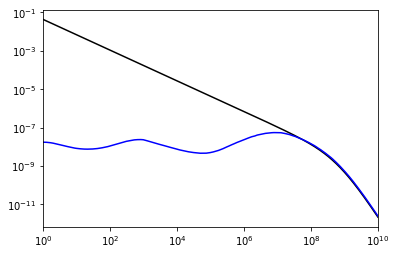

In [23]:
# read in and plot the data
EE, inputSpec, degradedSpec = np.loadtxt('for_Rong.csv', skiprows=1, delimiter=',', unpack=True)
plt.loglog(EE, inputSpec, 'k-')
plt.loglog(EE, degradedSpec, 'b-')
plt.xlim(1,1e10)